In [ ]:
!mkdir -p /root/.kaggle && mv kaggle.json /root/.kaggle

In [ ]:
#State Farm Distracted Driver Detection
!kaggle competitions download -c state-farm-distracted-driver-detection

100% 3.98G/4.00G [00:21<00:00, 228MB/s]
100% 4.00G/4.00G [00:22<00:00, 195MB/s]


In [ ]:
!unzip -q state*.zip

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Understanding Data

The 10 classes to predict are:

    c0: safe driving
    c1: texting - right
    c2: talking on the phone - right
    c3: texting - left
    c4: talking on the phone - left
    c5: operating the radio
    c6: drinking
    c7: reaching behind
    c8: hair and makeup
    c9: talking to passenger


In [ ]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

data_csv = pd.read_csv('./driver_imgs_list.csv')
data_csv.columns = [x.strip() for x in data_csv.columns]

data_csv

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg



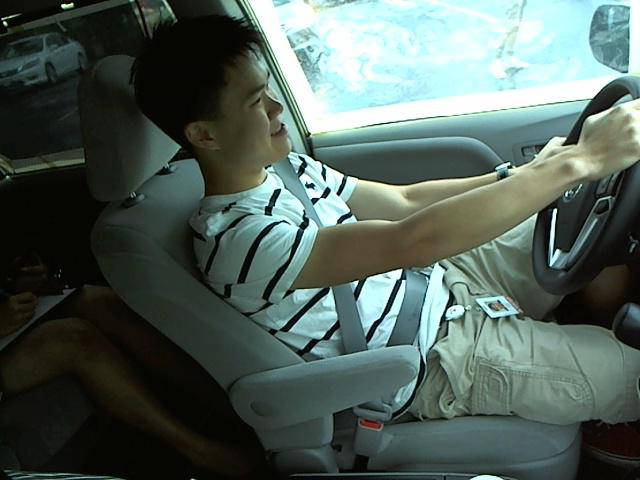

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from skimage import io

def show_image(classname, img):
    img = io.imread(f'imgs/train/{classname}/{img}')
    fig = px.imshow(img)
    fig.show()

show_image(data_csv.iloc[51].classname, data_csv.iloc[51].img)

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import animation
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.animation as animation

def animate_subject(snapshots, fps=30, nSeconds=15, anim_title="new_animation"):

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(8,8) )

    a = snapshots[0]
    im = plt.imshow(a, interpolation='none', aspect='auto', vmin=0, vmax=1)

    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )

        im.set_array(snapshots[i])
        return [im]

    anim = animation.FuncAnimation(
                                fig,
                                animate_func,
                                frames = nSeconds * fps,
                                interval = 1000/fps, # in ms
                                )

    anim.save(f'{anim_title}.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
    plt.clf()

    from IPython.display import Video

    return Video(f"{anim_title}.mp4", embed=True)

In [ ]:
df = data_csv[data_csv.subject == 'p081']
snapshots = [ mpimg.imread(f'/content/imgs/train/{df.iloc[x].classname}/{df.iloc[x].img}') for x in range(len(df))]
animate_subject(snapshots)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from plotly.subplots import make_subplots

subs = make_subplots(rows=1, cols=2, subplot_titles=["Subject", "Classname"])

subs.add_trace(go.Histogram(x=data_csv['subject']), row=1, col=1)
subs.add_trace(go.Histogram(x=data_csv['classname']), row=1, col=2)

subs.show()

# Preparing Data for Training/Validation

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

class state_farm_dataset(Dataset):
    def __init__(self, classes , images, transform=None, target_transform=None):
        self.labels = classes
        self.images = images
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = Image.open(f'/content/imgs/train/{self.labels[idx]}/{self.images[idx]}')
        label = self.labels[idx]

        if self.transform: img = self.transform(img)
        if self.target_transform: label = self.target_transform(label)

        return img, label


In [ ]:
def encode_labels(y):
    idx = int(y.split('c')[1])
    return idx

In [ ]:
def image_transform(x):
    x= T.Resize(200)(x)
    x =T.Grayscale()(x)
    return T.ToTensor()(x)


In [ ]:
batch_size=64
dataset = state_farm_dataset(data_csv.classname, data_csv.img,target_transform=encode_labels, transform=image_transform)
semi_train_data, train_data, test_data = random_split(dataset, [1000, 15000, 6424])
semi_train_dataloader = DataLoader(semi_train_data, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

torch.Size([64, 1, 200, 266])


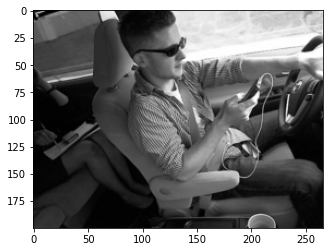

In [ ]:
sample_imgs, sample_labels = next(iter(semi_train_dataloader))
print(sample_imgs.shape)
plt.imshow(sample_imgs[0].squeeze(dim=0), cmap="gray")

## Image Sample of individual classes to predict

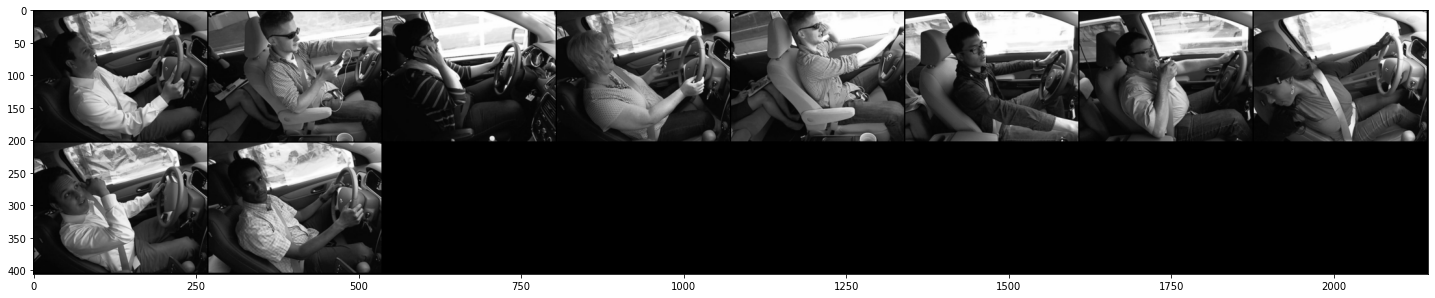

In [ ]:
import torchvision.utils as U

classes = torch.Tensor([])

for x in range(10):
    idx = (sample_labels == x).nonzero(as_tuple=False)[0][0]
    classes = torch.cat((classes, sample_imgs[idx]), 0)

grid = U.make_grid(classes.unsqueeze(dim=1), nrows=8)
plt.figure(figsize=(25, 25))
plt.imshow(grid.permute(1, 2, 0))

In [ ]:
print(len(semi_train_dataloader.dataset))
sample_imgs.shape

1000


torch.Size([64, 1, 200, 266])

# Defining Network and functions

In [ ]:
class BasicNetwork(nn.Module):
    def __init__(self):
        super(BasicNetwork, self).__init__()
        self.non_linearity = nn.Tanh
        self.max_pooling_size = 2

        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 3,(7,7), stride=3 ),
            self.non_linearity(),

            nn.Conv2d(3, 6, (3, 3), stride=2),
            self.non_linearity(),

            nn.Conv2d(6, 12, (2, 2)),
            self.non_linearity(),

            nn.MaxPool2d(self.max_pooling_size),
        )

        self.linear_stack = nn.Sequential(
            nn.Linear(3780, 10),
            nn.Sigmoid()
        )

    def forward(self, x):
        conv_output = self.conv_stack(x)
        # print("Convolution output: ", conv_output.shape, conv_output.flatten(start_dim=1).shape)
        linear_output = self.linear_stack(conv_output.flatten(start_dim=1))
        return linear_output


In [ ]:
test_net = BasicNetwork()
# test_net(sample_imgs).shape
test_net(sample_imgs).argmax(dim=1)

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

# Function Definations

In [ ]:
def train(model, dataloader, loss_func, optimizer_func, verbose=True):
    model.train()
    loss_arr = []

    for batch, (X, y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_func(pred, y)
        optimizer_func.zero_grad()
        loss.backward()
        optimizer_func.step()

        loss_arr.append(loss.item())

        if(verbose):
            if(batch%100 == 0):
                print(f'batch: {batch} loss: {loss.item()} [{batch*len(X)} / {len(dataloader.dataset)}]')
    return loss_arr

In [ ]:
@torch.no_grad()
def test(model, dataloader):
    correct = 0
    total = len(dataloader.dataset)


    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        correct += sum(pred.argmax(dim=1) == y)
    return [correct, total]

In [ ]:
import torchvision.utils as U

def print_filters(image, layer, nrows=8, show_input_image=True):
    if show_input_image: plt.imshow(image.squeeze(dim=0), cmap="gray")
    image = image.to(device)
    output = layer(image)
    grid = U.make_grid(output.unsqueeze(dim=1), nrow=output.shape[0]//nrows+1)
    return grid


# More tests on semi_train_dataloader

### Testing Multiple Learning Rates on the model

In [ ]:
def test_learning_rates(Network, dataloader, learning_rates):
    losses = []
    for lr in learning_rates:
        loss_func = nn.CrossEntropyLoss()
        main_net = Network().to(device)
        optimizer_func = torch.optim.SGD(main_net.parameters(), lr=lr)

        loss_arr = train(main_net, dataloader, loss_func, optimizer_func, verbose=False)

        losses.append(loss_arr)
    return losses

In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.9]
total_losses = test_learning_rates(BasicNetwork, semi_train_dataloader, learning_rates)

rows,cols, idx = 2, 3, 0
subs = make_subplots(rows=rows, cols=cols, subplot_titles=learning_rates)

for row in range(rows):
    for col in range(cols):
        if(row == 1 and col == 2): break;
        subs.add_trace(go.Scatter(y=total_losses[idx]), row=row+1, col=col+1)
        idx+=1

subs.show()

### Testing Model performance on epochs. To Figure out how long should the model be trained

In [ ]:
def test_epochs(Network, dataloader, number_of_epochs):
    epoch_list = []
    accuracy_list = []
    main_net = Network().to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer_func = torch.optim.SGD(main_net.parameters(), lr=0.9)

    for i in range(number_of_epochs):
        epoch_list.append(i)
        train(main_net, dataloader, loss_func, optimizer_func, verbose=False)
        correct, total = test(main_net, dataloader)
        accuracy_list.append(correct/total)
    return accuracy_list


In [ ]:
epoch_test_result = test_epochs(BasicNetwork, semi_train_dataloader, 20)

In [ ]:
epoch_test_result = [x.cpu() for x in epoch_test_result]
px.line(epoch_test_result)

# Actual Model Training



In [ ]:
use_existing = True
model_path = '/content/drive/MyDrive/Colab Notebooks/models/state_farm_distracted_driver_detection.pt'
myNet = torch.load(model_path) if use_existing else BasicNetwork()
myNet.to(device)

BasicNetwork(
  (conv_stack): Sequential(
    (0): Conv2d(1, 3, kernel_size=(7, 7), stride=(3, 3))
    (1): Tanh()
    (2): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2))
    (3): Tanh()
    (4): Conv2d(6, 12, kernel_size=(2, 2), stride=(1, 1))
    (5): Tanh()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_stack): Sequential(
    (0): Linear(in_features=3780, out_features=10, bias=True)
    (1): Sigmoid()
  )
)

In [ ]:
!mkdir -p losses

In [ ]:
# epochs = 10
epochs=4
loss_func = nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(myNet.parameters(), lr=0.1)

conv1_snaps = [] #0
conv2_snaps = [] #2
conv3_snaps = [] #4

save_model = False
counter = 0
for i in range(epochs):
    print("Epoch: ", i+1)
    loss_arr = train(myNet, train_dataloader, loss_func, optimizer)
    if save_model: torch.save(myNet, model_path)
    torch.save(loss_arr, f'losses/{counter}.txt')
    counter += 1

    conv1_output = myNet.conv_stack[0](sample_imgs[0].to(device))
    conv2_output = myNet.conv_stack[2](conv1_output)

    conv1_snaps.append(print_filters(sample_imgs[0], myNet.conv_stack[0], show_input_image=False))
    conv2_snaps.append(print_filters(conv1_output, myNet.conv_stack[2], show_input_image=False))
    conv3_snaps.append(print_filters(conv2_output, myNet.conv_stack[4], show_input_image=False))

Epoch:  1
batch: 0 loss: 2.305718421936035 [0 / 15000]
batch: 100 loss: 2.287231206893921 [6400 / 15000]
batch: 200 loss: 2.1480956077575684 [12800 / 15000]
Epoch:  2
batch: 0 loss: 2.039708137512207 [0 / 15000]
batch: 100 loss: 1.8748183250427246 [6400 / 15000]
batch: 200 loss: 1.846289873123169 [12800 / 15000]
Epoch:  3
batch: 0 loss: 1.9230154752731323 [0 / 15000]
batch: 100 loss: 1.8377186059951782 [6400 / 15000]
batch: 200 loss: 1.7618682384490967 [12800 / 15000]
Epoch:  4
batch: 0 loss: 1.752217173576355 [0 / 15000]
batch: 100 loss: 1.7345596551895142 [6400 / 15000]
batch: 200 loss: 1.6782913208007812 [12800 / 15000]


In [ ]:
[correct, total ] = test(myNet, test_dataloader)
print("Accuracy: ", correct/total)

Accuracy:  tensor(0.7856, device='cuda:0')


# Result Visualization

### Loss Graph

In [ ]:
total_loss = torch.Tensor([])
for i in range(10):
    temp = torch.Tensor(torch.load(f'losses/{i}.txt'))
    total_loss = torch.cat((total_loss, temp), 0)

px.line(y=total_loss)

## Confusion Matrix

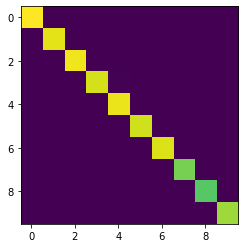

In [ ]:
import plotly.express as px

def build_confusion_matrix(main_net, dataloader, classes):
    total_preds = torch.Tensor([]).long().to(device)
    total_labels = torch.Tensor([]).long().to(device)

    for batch,(X, y) in enumerate(dataloader):
        X, y = X.to(device), y.long().to(device)
        pred = main_net(X).long()

        total_labels = torch.cat((total_labels, y), 0)
        total_preds = torch.cat((total_preds, pred.argmax(dim=1)), 0)

    matrix = torch.Tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] for x in range(classes)]).long().to(device)

    for idx, label in enumerate(total_labels):
        matrix[label][total_preds[idx]] += 1

    return matrix.cpu()

conf_matrix = build_confusion_matrix(myNet, test_dataloader, classes = 10)
px.imshow(conf_matrix, text_auto=True)

## Visualizing how filters changed during training

In [ ]:
#First Convolutional layer

grid_arr =  [U.make_grid(conv1_snaps[i].unsqueeze(dim=1), nrow=8).cpu().permute(1, 2, 0) for i in range(epochs)]
animate_subject(grid_arr, fps=1, nSeconds=10, anim_title="conv1")

....

....

...

<Figure size 576x576 with 0 Axes>

In [ ]:
#Second Convolutional Layer

grid_arr =  [U.make_grid(conv2_snaps[i].unsqueeze(dim=1), nrow=8).cpu().permute(1, 2, 0) for i in range(epochs)]
animate_subject(grid_arr, fps=1, nSeconds=10, anim_title="conv2")

....

....

...

<Figure size 576x576 with 0 Axes>

In [ ]:
#Third Convolutional Layer
grid_arr =  [U.make_grid(conv3_snaps[i].unsqueeze(dim=1), nrow=8).cpu().permute(1, 2, 0) for i in range(epochs)]
animate_subject(grid_arr, fps=1, nSeconds=10, anim_title="conv3")

....

....

...

<Figure size 576x576 with 0 Axes>

In [ ]:
import os
import numpy as np

# directory ='../input/state-farm-distracted-driver-detection/imgs/test'
directory = '/content/imgs/test'

column_names=['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
arr = np.array([['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']])
total = len(os.listdir(directory))

for idx, filename in enumerate(os.listdir(directory)):
    if idx > 500: break
    img = image_transform(Image.open(f'{directory}/{filename}')).to(device)
    pred = myNet(img.unsqueeze(dim=0))
    temp = np.append(filename, pred.cpu().detach().numpy())
    arr = np.append(arr, temp.reshape(1, -1), axis=0)

    if(idx % 1000 == 0):
        print(f'validation progress... [{idx}/{total}] {idx/total*100}')

submission = pd.DataFrame(arr,columns=column_names)[1:]
submission = submission.astype(dtype={
    'c0': float,
    'c1': float,
    'c2': float,
    'c3': float,
    'c4': float,
    'c5': float,
    'c6': float,
    'c7': float,
    'c8': float,
    'c9': float,
})
submission.to_csv('submission.csv')
submission

validation progress... [0/79726] 0.0


,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
1,img_42658.jpg,-3.720809,0.847270,1.269407,-4.879810,-7.498061,2.803599,2.838545,-0.654419,3.941398,5.284021
2,img_2306.jpg,3.137364,0.287620,-6.251207,1.739003,-1.869192,2.483927,-2.485553,-7.590916,9.393602,-0.395360
3,img_75505.jpg,2.339615,-0.954039,-5.068093,9.210575,6.473329,-0.206288,-6.393545,-6.692676,4.121619,-0.794417
4,img_93497.jpg,-5.387072,2.767678,-1.421923,-3.741013,-4.230356,-9.339679,2.136126,15.694867,1.253426,2.300462
5,img_82250.jpg,-2.114368,-3.166206,-4.210936,4.191949,1.111772,5.247763,-1.472048,0.339637,-1.930465,3.639458
...,...,...,...,...,...,...,...,...,...,...,...
497,img_93587.jpg,-0.259585,-2.782897,-1.926554,-5.087962,-5.952723,10.430196,-0.017673,-2.985791,6.121126,2.570097
498,img_22787.jpg,-0.167092,-4.390981,-3.408630,1.842446,-1.293179,0.085505,0.884987,0.127477,3.006225,5.147086
499,img_11406.jpg,1.575443,3.584920,1.197365,-1.595387,-5.041115,-4.370815,-1.159255,-0.891433,5.466800,2.308595
500,img_20828.jpg,-1.990735,-7.030858,-2.471291,-2.446463,6.875212,4.532173,0.887162,-0.585821,3.110847,0.872811
